In [ ]:
# %pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Multi layer perceptron functions

In [ ]:
def devsigmoid(sig):
    devsig = np.multiply(1 + sig, 1 - sig) / 2
    return devsig

def sigmoid(x):
    sig = 2/(1 + np.exp(-x)) - 1
    return sig


In [ ]:
# Avoid repeating names
class MLPerceptron():
    def __init__(self, n_input, n_output, n_hidden):
        self.n_hi = n_hidden
        self.n_in = n_input # dimension of each x
        self.n_out = n_output # dimension of each y
        # weight of first hidden layer
        self.weight = 0.02 * np.random.rand(n_hidden, n_input + 1) - 0.01# +1 for bias term
        # weight of second hidden layer
        self.v = 0.02 * np.random.rand(n_output, n_hidden + 1) - 0.01
        '''
        Initialization of weights should be SMALL enough!!!!!
        '''
        # for momentum update
        self.dw = np.zeros((n_hidden, n_input + 1))
        self.dv = np.zeros((n_output, n_hidden + 1))

    def forward_pass(self, x):
        m = x.shape[1]
        x = np.append(x, np.ones((1, m)), axis = 0)
        hin = self.weight @ x
        hout = sigmoid(hin)
        hout = np.append(hout, np.ones((1, m)), axis = 0)
        oin = self.v @ hout
        oout = sigmoid(oin)
        return hout, oout

    def backward_pass(self, t, hout, oout):
        delta_o = np.multiply(oout - t, devsigmoid(oout))
        delta_h = np.multiply(self.v.T @ delta_o , devsigmoid(hout))
        delta_h = delta_h[:self.n_hi, :]
        return delta_o, delta_h

    def weight_update(self, x, hout, delta_o, delta_h, lr = 0.001):
        #scalar factor
        self.weight = self.weight - lr * delta_h @ np.append(x, 1)
        self.v = self.v - lr * delta_o @ hout

    def compute_acc_and_loss(self, X, y):
        _, pred = self.forward_pass(X)
        pred = pred[0]
        # print(pred.shape)
        # print(y.shape)
        y_pred = np.where(pred > 0, 1, -1)
        acc = 1 - np.mean(0.5 * np.abs(y - y_pred))

        loss = 0.5 * np.mean((pred - y)**2)
        return acc, loss

    def momentum_update(self, X_train, y_train, alpha = 0.9, lr = 0.001):
        # update weights in batch mode using momentum

        hout, oout = self.forward_pass(X_train)
        delta_o, delta_h = self.backward_pass(y_train, hout, oout)
        m = X_train.shape[1]
        X = np.append(X_train, np.ones((1, m)), axis = 0)
        self.dw = alpha * self.dw - (1 - alpha) * delta_h @ X.T
        self.dv = alpha * self.dv - (1 - alpha) * delta_o @ hout.T

        self.weight = self.weight + lr * self.dw
        self.v = self.v + lr * self.dv

    def fit_with_test(self, X_train, y_train, X_test, y_test, alpha = 0.9, lr = 0.001, mode = 'batch', epochs = 100):
        loss_train = []
        acc_train = []
        loss_test = []
        acc_test = []

        if mode == 'batch':
            for _ in range(epochs):
                self.momentum_update(X_train, y_train, alpha, lr)
                acc1, loss1 = self.compute_acc_and_loss(X_train, y_train)
                acc2, loss2 = self.compute_acc_and_loss(X_test, y_test)
                acc_train.append(acc1)
                acc_test.append(acc2)
                loss_train.append(loss1)
                loss_test.append(loss2)

        elif mode == 'seq':
            m = X_train.shape[1]
            for _ in range(epochs):
                for i in range(m):
                    self.momentum_update(X_train[:,i].reshape(-1, 1), y_train[i], alpha, lr)
                acc1, loss1 = self.compute_acc_and_loss(X_train, y_train)
                acc2, loss2 = self.compute_acc_and_loss(X_test, y_test)
                acc_train.append(acc1)
                acc_test.append(acc2)
                loss_train.append(loss1)
                loss_test.append(loss2)

        else:
            print('Please specify mode as \'batch\' or \'seq\'')

        return loss_train, acc_train, loss_test, acc_test

    def fit(self, X_train, y_train, alpha = 0.9, lr = 0.001, mode = 'batch', epochs = 100):
        loss_train = []
        acc_train = []

        if mode == 'batch':
            for _ in range(epochs):
                self.momentum_update(X_train, y_train, alpha, lr)
                acc1, loss1 = self.compute_acc_and_loss(X_train, y_train)
                acc_train.append(acc1)
                loss_train.append(loss1)

        elif mode == 'seq':
            m = X_train.shape[1]
            for _ in range(epochs):
                for i in range(m):
                    # print(X_train[:,i].reshape(-1, 1))
                    self.momentum_update(X_train[:,i].reshape(-1, 1), y_train[i], alpha, lr)
                acc1, loss1 = self.compute_acc_and_loss(X_train, y_train)
                acc_train.append(acc1)
                loss_train.append(loss1)

        else:
            print('Please specify mode as \'batch\' or \'seq\'')

        return loss_train, acc_train

## generate data

In [ ]:
np.random.seed(10)
n = 100
#Can change mA, mB, sigmA and sigmaB
mA = [1, 0.3]
mB = [0, -0.1]
# mA = [0, 0]
# mB = [-2.5, 0]
sigmaA = 0.2
sigmaB = 0.3
classA = np.zeros((2, n))
classA[0, :] = np.random.randn(1, n) * sigmaA + mA[0]
classA[1, :] = np.random.randn(1, n) * sigmaA + mA[1]

classB = np.zeros((2, n))
classB[0, :n//2] = np.random.randn(1, n//2) * sigmaB + mB[0]
classB[1, :n//2] = np.random.randn(1, n//2) * sigmaB + mB[1]
classB[0, n//2:] = np.random.randn(1, n//2) * sigmaB + mB[0] + 2
classB[1, n//2:] = np.random.randn(1, n//2) * sigmaB + mB[1]



labels = np.concatenate((-np.ones(n), np.ones(n)))
data = np.concatenate((classA, classB), axis=1)
print(data.shape)
shuffle_index = np.random.permutation(2 * n)
data = data[:, shuffle_index]
labels = labels[shuffle_index]

(2, 200)


In [ ]:
np.random.seed(10)
n = 100
#Can change mA, mB, sigmA and sigmaB
mA = [1, 0.3]
mB = [0, -0.1]
# mA = [0, 0]
# mB = [-2.5, 0]
sigmaA = 0.2
sigmaB = 0.3
classA = np.zeros((2, n))
classA[0, :] = np.concatenate((np.random.randn(1, n//2) * sigmaA - mA[0], np.random.randn(1, n//2) * sigmaA + mA[0]), axis =1)
classA[1, :] = np.random.randn(1, n) * sigmaA + mA[1]

classB = np.zeros((2, n))
classB[0, :] = np.random.randn(1, n) * sigmaB + mB[0]
classB[1, :] = np.random.randn(1, n) * sigmaB + mB[1]



labels = np.concatenate((-np.ones(n), np.ones(n)))
data = np.concatenate((classA, classB), axis=1)
print(data.shape)
shuffle_index = np.random.permutation(2 * n)
data = data[:, shuffle_index]
labels = labels[shuffle_index]

(2, 200)


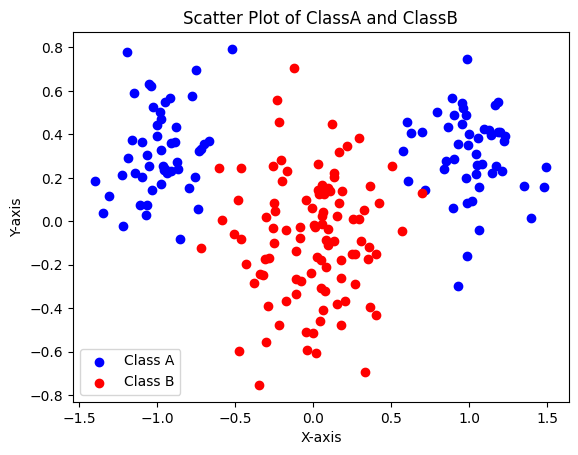

In [ ]:
plt.scatter(classA[0, :], classA[1, :], label='Class A', color='blue')

# Plotting classB
plt.scatter(classB[0, :], classB[1, :], label='Class B', color='red')

# Adding labels and legend
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot of ClassA and ClassB')
plt.legend()

# Display the plot
plt.show()

## Classification of linearly non-separable data

[]


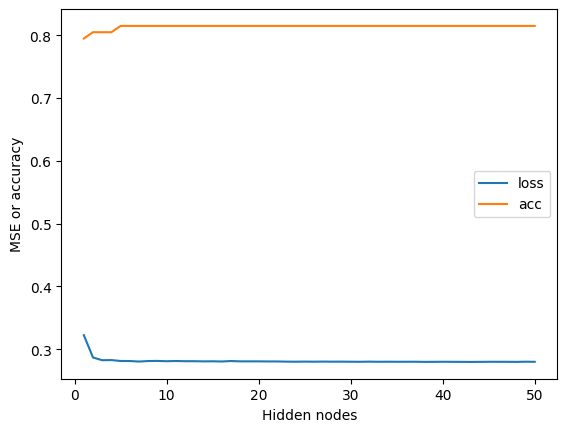

In [ ]:
loss_list = []
acc_list = []
index = []
nhi = range(1,51)
for hi in nhi:
    model = MLPerceptron(2, 1, hi)
    loss, acc = model.fit(data, labels, mode='batch', epochs= 1000, lr = 0.001)
    loss_list.append(loss[-1])
    acc_list.append(acc[-1])
    if acc[-1] >= 0.99:
        index.append(hi)
plt.plot(nhi, loss_list, label='loss')
plt.plot(nhi, acc_list, label = 'acc')
plt.xlabel('Hidden nodes')
plt.ylabel('MSE or accuracy')
plt.legend()
print(index)

In [ ]:
print([acc_list[i - 1] for i in index])

[0.995, 0.995, 0.995, 0.99, 0.995, 0.995, 0.995, 0.99, 0.99, 0.99, 0.99]


3.1.1.1
How many hidden nodes do you need to perfectly separate all the available data (if manageable at all given your data randomisation)?

Conclusion: number of hidden nodes are less than **22** (reached 99% accuracy)

In [ ]:
def subsample(classA, classB, na, nb):
    nA = classA.shape[1]
    nB = classB.shape[1]
    sub_indexA = np.random.choice(nA, na, False)
    sub_indexB = np.random.choice(nB, nb, False)
    sub_classA = classA[:,sub_indexA]
    sub_classB = classB[:,sub_indexB]

    rem_classA = np.delete(classA, sub_indexA, axis= 1)
    rem_classB = np.delete(classB, sub_indexB, axis= 1)

    data = np.concatenate((sub_classA, sub_classB), axis=1)
    labels = np.concatenate((-np.ones(na), np.ones(nb)))
    shuffle_index = np.random.permutation(na + nb)
    x_train = data[:, shuffle_index]
    y_train = labels[shuffle_index]

    data1 = np.concatenate((rem_classA, rem_classB), axis=1)
    labels1 = np.concatenate((-np.ones(nA - na), np.ones(nB - nb)))
    shuffle_index1 = np.random.permutation(nA - na + nB - nb)
    x_val = data1[:, shuffle_index1]
    y_val = labels1[shuffle_index1]

    return x_train, y_train, x_val, y_val

In [ ]:
# remove random 25% from each class
x_train1, y_train1, x_val1, y_val1 = subsample(classA, classB, 75, 75)
# remove random 50% from classA
x_train2, y_train2, x_val2, y_val2 = subsample(classA, classB, 50, 100)



# 20% from a subset of classA for which classA(1,:)<0 and 80% from a subset of classA for which classA(1,:)>0

index_negative = np.where(classA[0, :] < 0)
index_positive = np.where(classA[0, :] > 0)
sub_index_n = np.random.choice(index_negative[0], int(0.8*index_negative[0].size), False)
# print(sub_index_n)
sub_index_p = np.random.choice(index_positive[0], int(0.2*index_positive[0].size), False)
classA_rem = np.delete(classA, np.concatenate((sub_index_n, sub_index_p)), axis= 1)
classA_sub = classA[:, np.concatenate((sub_index_n, sub_index_p))]
data = np.concatenate((classA_sub, classB), axis=1)
labels = np.concatenate((-np.ones(classA_sub.shape[1]), np.ones(classB.shape[1])))
shuffle_index = np.random.permutation(labels.size)
x_train3 = data[:, shuffle_index]
y_train3 = labels[shuffle_index]

labels1 = -np.ones(classA_rem.shape[1])
shuffle_index1 = np.random.permutation(labels1.size)
x_val3 = classA_rem[:, shuffle_index1]
y_val3 = labels1[shuffle_index1]
# dataset_all = [(data1, label1), (data2, label2), (data3, label3), (data4, label4)]
d1 = (x_train1, y_train1, x_val1, y_val1)
d2 = (x_train2, y_train2, x_val2, y_val2)
d3 = (x_train3, y_train3, x_val3, y_val3)

In [ ]:
def diff_hidden_layer(l, n_hidden, e, dataset1, dataset2, dataset3, m= 'batch'):
    # number of hidden layers = 5
    model1 = MLPerceptron(2,1,n_hidden)
    model2 = MLPerceptron(2,1,n_hidden)
    model3 = MLPerceptron(2,1,n_hidden)
    loss_train1, _, loss_val1, _ = model1.fit_with_test(dataset1[0], dataset1[1], dataset1[2], dataset1[3], epochs = e, mode=m, lr = l)
    loss_train2, _, loss_val2, _ = model2.fit_with_test(dataset2[0], dataset2[1], dataset2[2], dataset2[3], epochs = e, mode=m, lr = l)
    loss_train3, _, loss_val3, _ = model3.fit_with_test(dataset3[0], dataset3[1], dataset3[2], dataset3[3], epochs = e, mode=m, lr = l)

    plt.plot(loss_train1, c='green',label = 'loss_train1')
    plt.plot(loss_val1, c='green',linestyle = '--',label = 'loss_val1')
    plt.plot(loss_train2, c='red',label = 'loss_train2')
    plt.plot(loss_val2, c='red',linestyle = '--', label = 'loss_val2')
    plt.plot(loss_train3, c='blue',label = 'loss_train3')
    plt.plot(loss_val3, c='blue',linestyle = '--', label = 'loss_val3')
    plt.xlabel('Epoch')

    plt.legend()


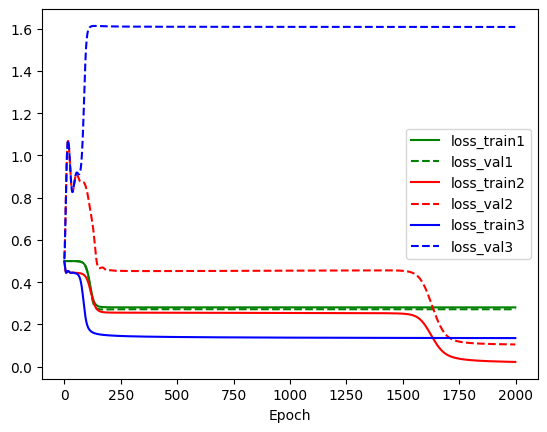

In [ ]:
# default: number of hidden layers = 10
diff_hidden_layer(0.01, 10, 2000, d1, d2, d3)

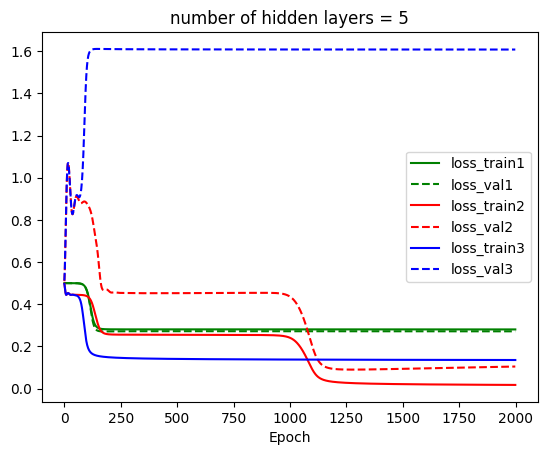

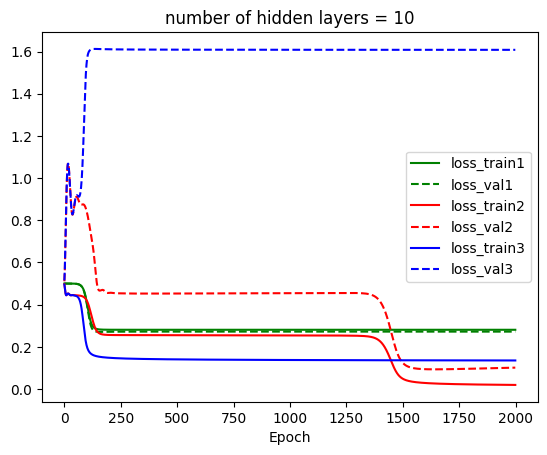

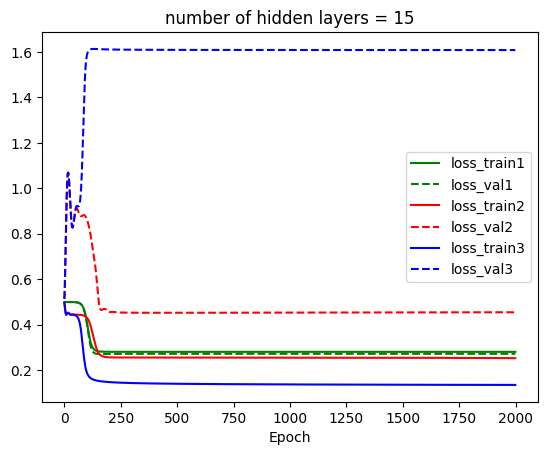

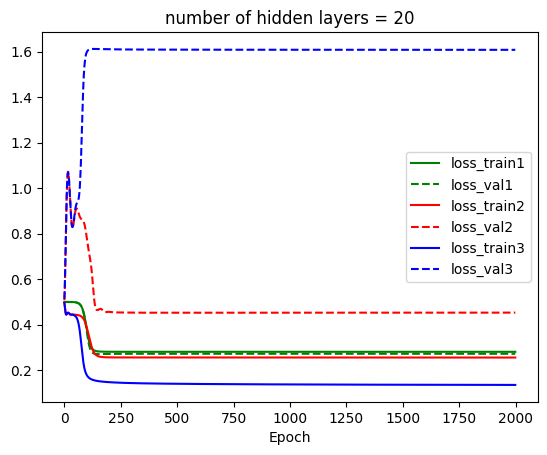

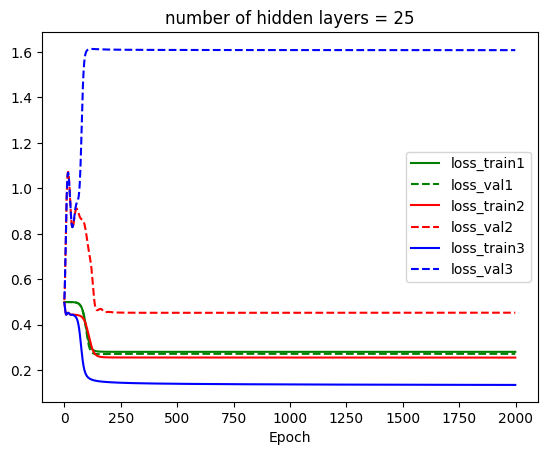

In [ ]:
# number of hidden layers = 5, 10, 15, 20, 25, 30

for i in range(5, 30, 5):
    diff_hidden_layer(0.01, i, 2000, d1, d2, d3)
    plt.title(f'number of hidden layers = {i}')
    plt.show()

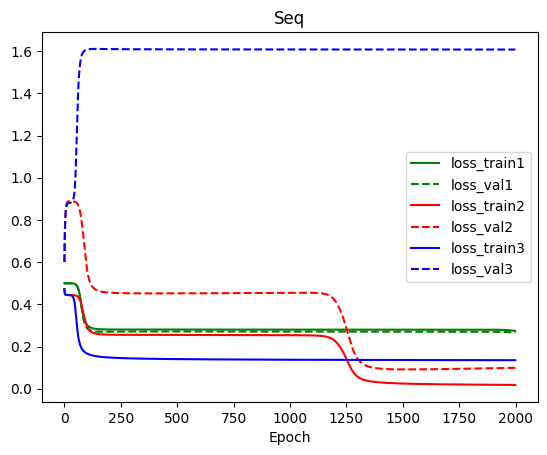

Text(0.5, 1.0, 'Batch')

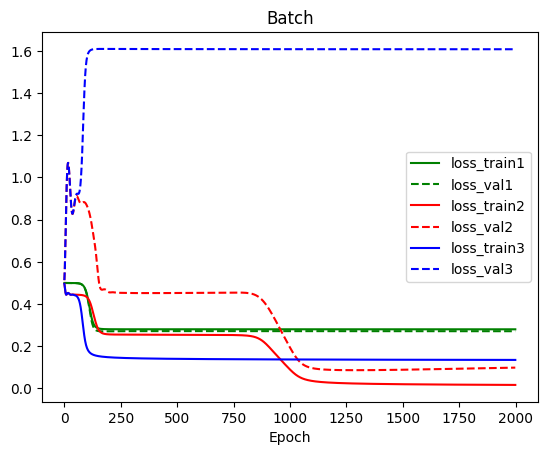

In [ ]:
diff_hidden_layer(0.01, 5, 2000, d1, d2, d3,m='seq')
plt.title('Seq')
plt.show()
diff_hidden_layer(0.01, 5, 2000, d1, d2, d3)
plt.title('Batch')

In [ ]:
n_hidden = 10
e = 2000
l = 0.01
model1 = MLPerceptron(2,1,n_hidden)
model2 = MLPerceptron(2,1,n_hidden)
model3 = MLPerceptron(2,1,n_hidden)
loss_train1, _, loss_val1, _ = model1.fit_with_test(d1[0], d1[1], d1[2], d1[3], epochs = e, lr = l)
loss_train2, _, loss_val2, _ = model2.fit_with_test(d2[0], d2[1], d2[2], d2[3], epochs = e, lr = l)
loss_train3, _, loss_val3, _ = model3.fit_with_test(d3[0], d3[1], d3[2], d3[3], epochs = e, lr = l)

In [ ]:
x_range = (-2, 2)
y_range = (-2, 2)

# Number of points to generate
num_points = 100000

# Generate random uniform samples for x and y
x_values = np.random.uniform(low=x_range[0], high=x_range[1], size=num_points)
y_values = np.random.uniform(low=y_range[0], high=y_range[1], size=num_points)

samples = np.vstack((x_values, y_values))

_, pred1 = model1.forward_pass(samples)
_, pred2 = model2.forward_pass(samples)
_, pred3 = model3.forward_pass(samples)

pred1 = pred1[0]
pred2 = pred2[0]
pred3 = pred3[0]
upper_bound = 0.01
lower_bound = -0.01

db_index1 = np.where(np.logical_and(pred1 > lower_bound, pred1 < upper_bound))
# db_index = np.where(pred1 == 0)
db_index2 = np.where(np.logical_and(pred2 > lower_bound, pred2 < upper_bound))
db_index3 = np.where(np.logical_and(pred3 > lower_bound, pred3 < upper_bound))

db1 = samples[:, db_index1]
db2 = samples[:, db_index2]
db3 = samples[:, db_index3]

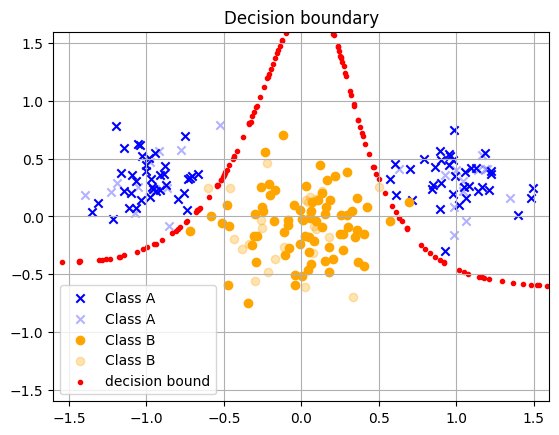

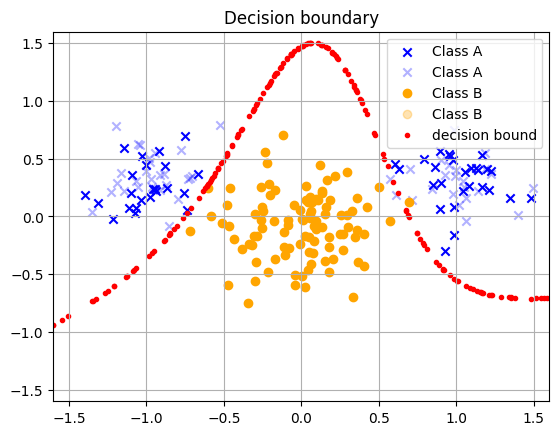

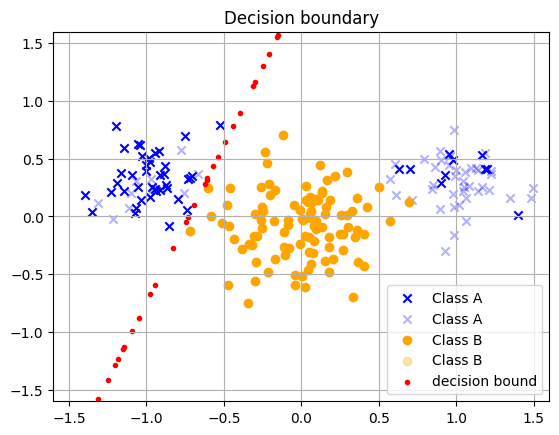

In [ ]:
plt.scatter(x_train1[0, y_train1 == -1], x_train1[1, y_train1 == -1], label='Class A', marker='x', c='blue')
plt.scatter(x_val1[0, y_val1 == -1], x_val1[1, y_val1 == -1], alpha= 0.3, label='Class A', marker='x',c='blue')
plt.scatter(x_train1[0, y_train1 == 1], x_train1[1, y_train1 == 1], label='Class B', marker='o',c='orange')
plt.scatter(x_val1[0, y_val1 == 1], x_val1[1, y_val1 == 1], alpha= 0.3, label='Class B', marker='o',c='orange')
plt.scatter(db1[0, :], db1[1, :], label = 'decision bound', c = 'red', marker='.')
plt.title('Decision boundary')
plt.grid(True)
plt.legend()
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.show()

plt.scatter(x_train2[0, y_train2 == -1], x_train2[1, y_train2 == -1], label='Class A', marker='x', c='blue')
plt.scatter(x_val2[0, y_val2 == -1], x_val2[1, y_val2 == -1], alpha= 0.3, label='Class A', marker='x',c='blue')
plt.scatter(x_train2[0, y_train2 == 1], x_train2[1, y_train2 == 1], label='Class B', marker='o',c='orange')
plt.scatter(x_val2[0, y_val2 == 1], x_val2[1, y_val2 == 1], alpha= 0.3, label='Class B', marker='o',c='orange')
plt.scatter(db2[0, :], db2[1, :], label = 'decision bound', c = 'red', marker='.')
plt.title('Decision boundary')
plt.grid(True)
plt.legend()
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.show()

plt.scatter(x_train3[0, y_train3 == -1], x_train3[1, y_train3 == -1], label='Class A', marker='x', c='blue')
plt.scatter(x_val3[0, y_val3 == -1], x_val3[1, y_val3 == -1], alpha= 0.3, label='Class A', marker='x',c='blue')
plt.scatter(x_train3[0, y_train3 == 1], x_train3[1, y_train3 == 1], label='Class B', marker='o',c='orange')
plt.scatter(x_val3[0, y_val3 == 1], x_val3[1, y_val3 == 1], alpha= 0.3, label='Class B', marker='o',c='orange')
plt.scatter(db3[0, :], db3[1, :], label = 'decision bound', c = 'red', marker='.')
plt.title('Decision boundary')
plt.grid(True)
plt.legend()
plt.xlim(-1.6, 1.6)
plt.ylim(-1.6, 1.6)
plt.show()


3.1.1.2
- How do the learning/error curves for training and validation sets
compare? Are they similar? When do you observe more dissimilarity?

    Not similar. More dissimilarity when the validation sets shift more from training sets.

- How do these curves and the network performance depend on the size
of the hidden layer in various training/validation data congurations
(the aforementioned subsampling options)?

    Large hidden nodes result in Overfitting;

- Is there any difference between a batch and sequential learning ap
proach in terms of the validation performance?

    Errors of validation set in sequential converge little bit slower than batch. Batch is more sensitive to random initialization.

- Make an attempt at approximating the resulting decision boundary,
 i.e. where the network output is 0 (between the target labels of-1
 and 1 for two classes, respectively).

    

## Function approximation

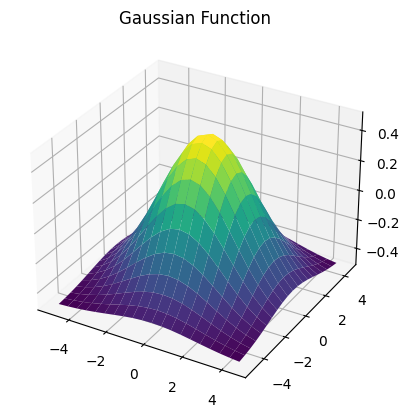

In [ ]:

x = np.arange(-5, 5, 0.5)
y = np.arange(-5, 5, 0.5)

X, Y = np.meshgrid(x, y)
Z = np.exp(-X**2 * 0.1) * np.exp(-Y**2 * 0.1) - 0.5
#print(X.shape)
#print(Y.shape)
#print(Z.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
plt.title("Gaussian Function")
plt.show()

ndata = X.size
print(ndata)
patterns = np.vstack((X.flatten(), Y.flatten()))
targets = Z.flatten()



Train the network

In [ ]:

n_input = 2  # x and y
n_output = 1  # z
n_hidden = 21

mlp = MLPerceptron(n_input, n_output, n_hidden)

X_train = patterns
y_train = targets

# Train the MLP
mlp.fit(patterns, targets, alpha=0.9, lr=0.01, mode='batch', epochs=3000)
print('')


Visualise the approximated function

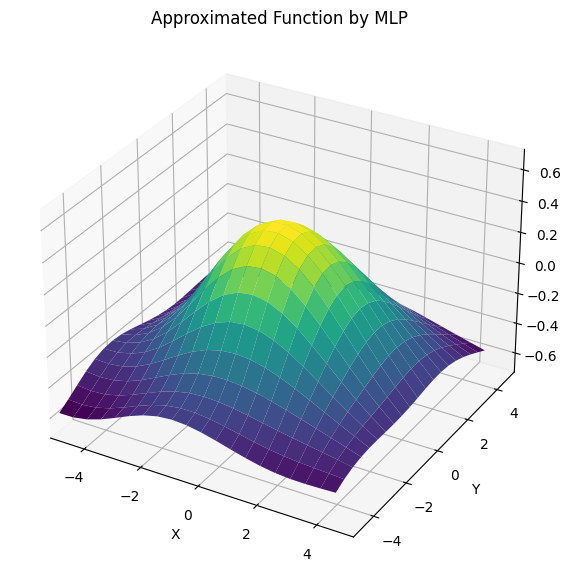

In [ ]:



_, out = mlp.forward_pass(patterns)

ZZ = out.reshape(X.shape)

# Visualize the approximation
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, ZZ, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Approximated Function by MLP')
ax.set_xlim([-5, 5])
ax.set_ylim([-5, 5])
ax.set_zlim([-0.7, 0.7])
plt.show()


Evaluate generalisation performance

best model 6


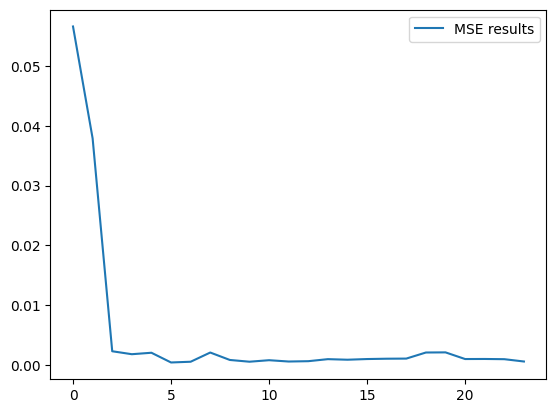

In [ ]:
#print(patterns.shape)
#print(targets.shape)

n_input = patterns.shape[0]
n_output = 1
#targets_reshaped = targets.reshape(1, -1)

hidden_nodes_range = range(1, 25)
#print(hidden_nodes_range)
mse_results = []
lowest_mse = 10000

for n_hidden in hidden_nodes_range:

    mlp = MLPerceptron(n_input, n_output, n_hidden)
    mlp.fit(patterns, targets, alpha=0.9, lr=0.01, mode='batch', epochs=2000)
    _, pred = mlp.forward_pass(patterns)
    mse = np.mean((targets - pred)**2)
    mse_results.append(mse)
    if (mse<lowest_mse):
      lowest_mse = mse
      lowest_index = n_hidden



print("best model", lowest_index)
plt.plot(mse_results, label = 'MSE results')
plt.legend()

In [ ]:
n_hidden_best = lowest_index
sample_sizes = [0.8, 0.6, 0.4, 0.2]  # Portion of the dataset to use for training
mse_results_by_sample_size = []

for sample_size in sample_sizes:

    mlp = MLPerceptron(n_input, n_output, n_hidden_best)
    mlp.fit(X_train, y_train, alpha=0.9, lr=0.001, mode='batch', epochs=100)
    _, pred = mlp.forward_pass(patterns)
    mse = np.mean((targets - pred)**2)
    print(sample_size, mse)

0.8 0.06769452861262218
0.6 0.06766216717181915
0.4 0.06769550758631394
0.2 0.06768693157954432
